In [1]:
#Import the ne
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from sklearn import datasets, metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sqlalchemy import create_engine

In [34]:
#create the credentials
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
heart_db = 'heartdisease'

#create the engine
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, heart_db))

heart_df = pd.read_sql_query('select * from heartdisease',con=engine)

#dispose of the engine
engine.dispose()

In [64]:
#load the dataset from the library
iris = datasets.load_iris()
X = iris.data
y = iris.target

#standardize the data
scaler = StandardScaler()
X_trans = scaler.fit_transform(X)

In [65]:
#make a function to allow for easy calling of different clusters
def sil_test(cluster):
    sil = KMeans(n_clusters=cluster, random_state=357).fit_predict(X_trans)
    print(metrics.silhouette_score(X_trans, sil, metric='euclidean'))

In [66]:
sil_test(2)

0.5817500491982808


In [67]:
sil_test(3)

0.45994823920518635


Even though three is the proper amount of clusters, the silhouette for n_clusters=2 is better because the nearest cluster is always the same cluster instead of occasionally being a different cluster. While that might initially sound counterintuitive, a single cluster will have a set value while two clusters can have varying values.

In [68]:
#pulling the code from the lesson again
# Define the features and the outcome
X = heart_df.iloc[:302, :13]
y = heart_df.iloc[:302, 13]

# Replace missing values (marked by `?`) with a `0`
X = X.replace(to_replace='?', value=0)

# Binarize `y` so that `1` means heart disease diagnosis and `0` means no diagnosis
y = np.where(y > 0, 0, 1)

In [69]:
#standardize the new X set
X_trans = scaler.fit_transform(X)

#to keep the data from being unwieldy, we'll use PCA to get the
#two primary classifiers
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_trans)

In [70]:
#split the data in half for PCA and non-PCA
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(X_trans,
                                    X_pca, test_size=0.5, random_state=357)

In [71]:
#make a df and pass the tuples through them to allow for visualization
ypred = pd.DataFrame()

In [72]:
for counter, data in enumerate([(X_half1, X_pcahalf1),
                                (X_half2, X_pcahalf2)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 5):
        pred = KMeans(n_clusters=nclust, random_state=357).fit_predict(data[counter])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

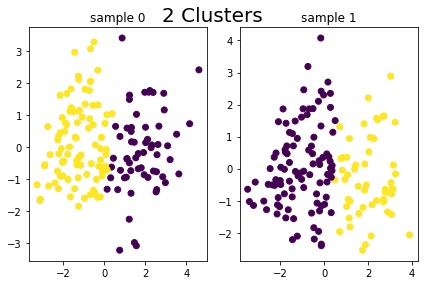

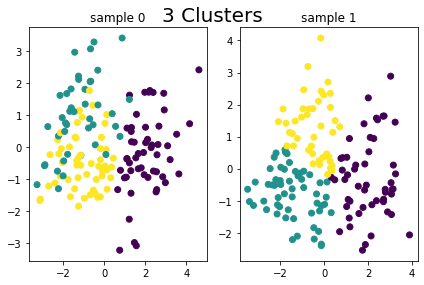

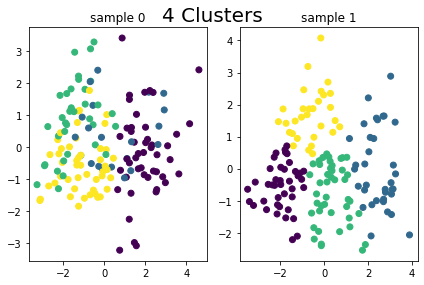

In [73]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 5):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(1, 2)
    
    # Make a plot for each sample.
    for i in range(2):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title('sample {}'.format(i))
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

Two clusters give us the best separation from a visual standpoint.

In [76]:
def ari_test(n):
    km = KMeans(n_clusters=n, random_state=357).fit_predict(X_trans)
    print(metrics.adjusted_rand_score(y, km))

In [77]:
ari_test(2)

0.43661540614807665


In [78]:
ari_test(3)

0.280694132678885


In [79]:
ari_test(4)

0.20760985426559772


ARI for two clusters is the best of the group.